# Project milstone 1 draft

In [79]:
import ipywidgets as widgets
from ipywidgets import interactive
import requests
import json
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
from ipywidgets import interact, interactive, fixed, interact_manual
#from functools import cache
pd.options.display.max_columns = 100
os.chdir('C:\\Users\\chait\\OneDrive\\Documents\\School\\IFT_6758\\2.Project\\Milestone1')

## 1. Warm-up (10%)

In [4]:
question_1 = importlib.import_module("ift6758-project-template-main.ift6758.data.question_1")

In [5]:
df = question_1.get_player_stats(2018, 'goalies') # the function docstring is wrong, 2018 is the correct year to get data from 2017-2018

Retrieving data from 'https://www.hockey-reference.com/leagues/NHL_2018_goalies.html'...


### 1.Q1
Sort the goalies by their save percentage (‘SV%’), which is the ratio of their shots saved over the total number of shots they faced. What issues do you notice by using this metric to rank goalies? What could be done to deal with this? Add this discussion to your blog post (no need for the dataframe or a plot yet).
Note: You don’t need to create a fancy new metric here. If you’d like, you can do a sanity check against the official NHL stats webpage. You also don’t need to reproduce any particular ranking on the NHL page; if your approach is reasonable you will get full marks.

A: The main problem is that goalies who performed well over very small sample size end up near the top of the list. If the goalie's sample size is too small, we don't want to include him in a list of top performing goalies. One simple filter would be to only keep goalies who played in at least half of the games (>= 41GP)

In [6]:
df.sort_values('SV%', ascending = False, inplace = True)
df.head(10)

,Rk,Player,Age,Tm,GP,GS,W,L,T/O,GA,SA,SV,SV%,GAA,SO,GPS,MIN,QS,QS%,RBS,GA%-,GSAA,G,A,PTS,PIM
27,29,Scott Foster,36,CHI,1,0,0,0,0,0,7,7,1.000,0.00,0,0.1,14,0,NaN,0,NaN,NaN,0,0,0,0
88,95,Adam Wilcox,25,BUF,1,0,0,1,0,0,14,14,1.000,0.00,0,0.2,39,0,NaN,0,NaN,NaN,0,0,0,0
51,55,Marek Langhamer,23,ARI,1,0,0,0,0,0,10,10,1.000,0.00,0,0.2,29,0,NaN,0,NaN,NaN,0,0,0,0
16,17,Oscar Dansk,23,VEG,4,3,3,0,0,5,93,88,.946,1.78,1,0.9,169,3,1.000,0,NaN,NaN,0,0,0,0
3,4,Ken Appleby,22,NJD,3,1,0,1,0,3,55,52,.945,1.45,0,0.5,124,0,.000,0,NaN,NaN,0,0,0,0
37,39,Andrew Hammond,29,COL,1,1,0,1,0,2,33,31,.939,2.06,0,0.3,58,1,1.000,0,NaN,NaN,0,0,0,0
83,90,Linus Ullmark,24,BUF,5,3,1,2,0,8,123,115,.935,2.00,0,1.0,240,2,.667,0,NaN,NaN,0,0,0,0
60,64,Curtis McElhinney,34,TOR,18,15,11,5,1,35,528,493,.934,2.14,3,4.2,979,8,.533,1,76,11.34,0,1,1,0
43,45,Carter Hutton,32,STL,32,26,17,7,3,56,810,754,.931,2.09,3,6.2,1610,19,.731,2,79,15.09,0,0,0,2
70,77,Antti Raanta,28,ARI,47,46,21,17,6,97,1388,1291,.930,2.24,3,10.4,2599,32,.696,6,80,24.82,0,0,0,0


### 1.Q2
Filter out the goalies using your proposed approach above, and produce a bar plot with player names on the y-axis and save percentage (‘SV%’) on the x-axis. You can keep the top 20 goalies. Include this figure in your blog post; ensure all of the axes are labeled and the title is appropriate.

In [7]:
df['GP'] = pd.to_numeric(df['GP'])
df['SV%'] = pd.to_numeric(df['SV%'])
df = df[ df['GP'] >= 41].head(20)

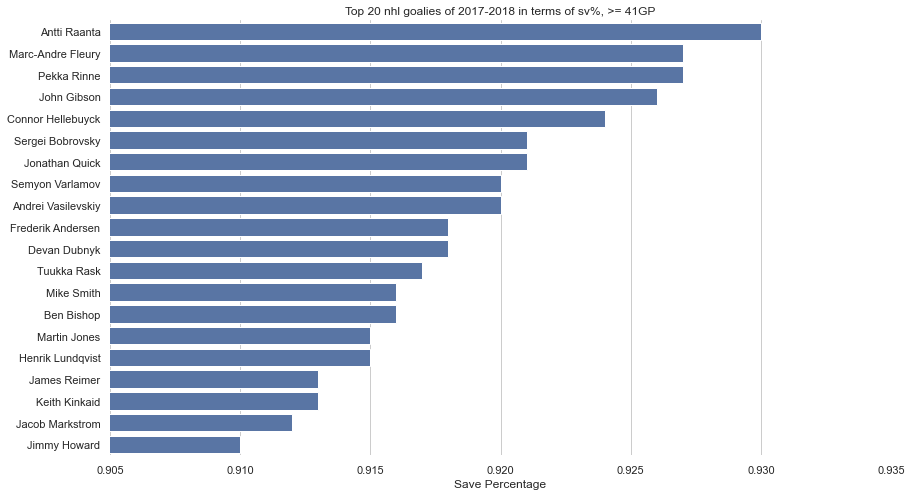

In [8]:
sns.set_theme(style='whitegrid')
f, ax = plt.subplots(figsize=(14, 8))
sns.barplot(x='SV%', y="Player", data=df, label='Total', color='b')
ax.set(xlim=(0.905, 0.935), ylabel='', xlabel='Save Percentage', title = 'Top 20 nhl goalies of 2017-2018 in terms of sv%, >= 41GP')
sns.despine(left=True, bottom=True)


### 1.Q3
Save percentage is obviously not a very comprehensive feature. Discuss what other features could potentially be useful in determining a goalie’s performance. You do not need to implement anything unless you really want to, all that’s required is a short paragraph of discussion.

A: Jusitfy and explain even strength SV%, xGA%, HDsc SV%, sc SV%. (see 'NHL advanced' section of https://www.hockey-reference.com/players/a/allenja01.html)

GAA (number of gaols let in for every 60 mins of play) can be used to a metric to determine goaltenders performance. Lower the GAA, better the stats of the palyer. However, when comparing, a threshold should be established for number of minutes played by each player before comparing.

A ratio between number of goals saved and total games played can also be used as a metric. Higher the ratio better the performance of the goaltender.

## 2. Data Acquisition (25%)

In [9]:
config_folder_path = 'C:\\Users\\chait\\OneDrive\\Documents\\School\\IFT_6758\\2.Project\\Milestone1\\'

In [10]:

def get_file(game_id, folder_path):
    """
    Check if file is already downloaded.
        If yes, return the file path
        If not, check if it exists on the nhl api.
            If it does, save it locally and return the path
            If it doesn't, return None
    """
    
    file_path = folder_path + str(game_id) + '.json'
    if not os.path.isfile(file_path):
        data = requests.get(f'https://statsapi.web.nhl.com/api/v1/game/{game_id}/feed/live/')
        if (data.status_code == 404):
            return None
        with open(file_path, 'w') as f:
            json.dump(data.json(), f)
            
    return file_path

The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 03 = playoffs, 04 = all-star. The final 4 digits identify the specific game number. For regular season and preseason games, this ranges from 0001 to the number of games played. (1271 for seasons with 31 teams (2017 and onwards) and 1230 for seasons with 30 teams). For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

In [11]:
def get_season_files(seasons = [2016, 2017, 2018, 2019, 2020], folder_path = config_folder_path, clear_existing_files = False):
    
    """download all regular season + playoff files from specified seasons into directory.
     Combine into one file, which is returned and saved at top of directory"""
    
    if clear_existing_files:
        filelist = [ f for f in os.listdir(config_folder_path)  if f.endswith('.json') ]
        for f in filelist:
            os.remove(os.path.join(config_folder_path, f))
    
    result = list()
    
    for season in seasons:
        
        # get regular season games
        file_exists = True
        game_id = season * 1000000 + 20000 + 1 #id of first game in reg season
        while(file_exists): 
            file = get_file(game_id, folder_path)
            if file is not None:
                with open(file, 'r') as f:
                    result.append(json.load(f))
            else:
                file_exists = False
            game_id +=1
        
                    
        # get playoff games
        
        if season == 2019: # in 2019-2020 there was a playoff round 0 due to covid
            first_round = 0
        else:
            first_round = 1

        for playoff_round in range(first_round, 5):
            for matchup in range(1, 2**(4-playoff_round-1*(playoff_round==0))+1):
                file_exists = True
                game_id = season * 1000000 + 30000 + playoff_round * 100 + matchup * 10 + 1   # id of first game in playoff round & matchup
                while(file_exists):
                    file = get_file(game_id, folder_path)
                    if file is not None:
                        with open(file, 'r') as f:
                            result.append(json.load(f))
                    else:
                        file_exists = False
                    game_id +=1
        
    output_file_name = '0_all_games_' + "".join([str(season) for season in seasons]) + '.json'
    with open(folder_path + output_file_name, 'w') as f:
            json.dump(result, f)
                
    return result 

In [12]:
result_file = get_season_files(seasons = [2018], clear_existing_files = False)

## 3. Interactive Debugging Tool (bonus 5%)
need to run this after the q4 code

In [28]:
df['game_id_numeric'] = pd.to_numeric(df['game_id'])
df = df.reset_index()

def view_df(game_id):
    
    return print(df[df['game_id'] == game_id])

game_id_slider = widgets.IntSlider(min=min(df['game_id_numeric']), max = max(df['game_id_numeric']) )
widgets.interactive(view_df, game_id = game_id_slider)

interactive(children=(IntSlider(value=2018020001, description='game_id', max=2018030417, min=2018020001), Outp…

In [54]:
# Code added by Chaitanya in response to Q3

In [625]:
#Game year selection

year = widgets.IntSlider(
    value=2017,
    min=2016,
    max=2020,
    step=1,
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [626]:
# Toggle between regular season and play-offs

game_type = widgets.RadioButtons(
    options=['Regular', 'Playoffs'],
    description='Season:',
    disabled=False
)
if game_type.value=="Regular":
    k = "R"
else:
    k = "P"

In [636]:
# Home team selection from pull-dowm menu

Home_team = widgets.Dropdown(
    description='Home Team:   ',
    value='Pittsburgh Penguins',
    options=df['home_team'].unique().tolist()
)

In [646]:
# Away team selection from pull-dowm menu

Away_team = widgets.Dropdown(
    description='Away Team:   ',
    value='New York Rangers',
    options=df['away_team'].unique().tolist()
)

In [638]:
container = widgets.HBox(children=[year, game_type])
container

In [639]:
container2 = widgets.HBox(children=[Home_team, Away_team])
container2

In [640]:
def validate():
    if Home_team.value in df['home_team'].unique() and Away_team.value in df['away_team'].unique():
        if Home_team.value != Away_team.value:
            return True      
    else:
        return False

In [644]:
def games_available():
    if validate():
        df_group1 = df.groupby('home_team')
        df_group2 = df_group1.get_group(Home_team.value)
        df_group3 = df_group2.groupby('away_team')
        df_group4 = df_group3.get_group(Away_team.value)
        df_group5 = df_group4.groupby('season_type')
        df_group6 = df_group5.get_group(k)
        df_group7 = df_group6.groupby('season')
        season_available = df_group6['season'].unique()
        game_available = df_group6['game_id'].unique()

        if str(year.value*10000+(year.value+1)) in season_available:
            df_group8 =  df_group7.get_group(str(year.value*10000+(year.value+1)))
            list = df_group8['game_id'].unique().tolist()
        else:
            list = None
            
        avaibale_games = widgets.Dropdown(
            description='Avaibale Games:   ',
            value=list[0],
            options=list
        )
        return avaibale_games
        
games_av = games_available()
games_av

Dropdown(description='Avaibale Games:   ', options=(2018020739,), value=2018020739)

In [645]:
match_summary =[]
match_summary_col = ['Home Team','Home Team Score','Home Team Attempts','Away Team','Away Team Score','Away Team Attempts','Winner']
count = 0
with open(f'{config_folder_path}{games_av.value}.json','r') as f:
    data_Q3 = json.load(f)
    df_Q3 = pd.DataFrame(data_Q3)

# df_Q3  is a data frame created for Q3
        
    if df_Q3['liveData']['linescore']['hasShootout'] is not True:
        Home_Team = df_Q3['gameData']['teams']['home']['name']
        Away_Team = df_Q3['gameData']['teams']['away']['name']
        Home_Team_Score = df_Q3['liveData']['linescore']['teams']['home']['goals']
        Home_Team_Attempts = df_Q3['liveData']['linescore']['teams']['home']['shotsOnGoal']
        Away_Team_Score = df_Q3['liveData']['linescore']['teams']['away']['goals']
        Away_Team_Attempts = df_Q3['liveData']['linescore']['teams']['away']['shotsOnGoal']
        if Home_Team_Score > Away_Team_Score:
            winner = Home_Team
        else:
            winner = Away_Team
        match_summary.append([Home_Team,Home_Team_Score,Home_Team_Attempts,Away_Team,Away_Team_Score,Away_Team_Attempts,winner])
        match_summary = pd.DataFrame(match_summary, columns = match_summary_col)
 
match_summary        


,Home Team,Home Team Score,Home Team Attempts,Away Team,Away Team Score,Away Team Attempts,Winner
0,Vancouver Canucks,4,23,Buffalo Sabres,3,39,Vancouver Canucks


In [296]:
df['game_id_numeric'] = pd.to_numeric(df['game_id'])
list = df['game_id_numeric'].unique().tolist()

def Game_ID(val):
    match_summary =[]
    match_summary_col = ['Home Team','Home Team Score','Home Team Attempts','Away Team','Away Team Score','Away Team Attempts','Winner']
    count = 0
    with open(f'{config_folder_path}{val}.json','r') as f:
        data_Q3 = json.load(f)
        df_Q3 = pd.DataFrame(data_Q3)

# df_Q3  is a data frame created for Q3
        
    if df_Q3['liveData']['linescore']['hasShootout'] is not True:
        Home_Team = df_Q3['gameData']['teams']['home']['name']
        Away_Team = df_Q3['gameData']['teams']['away']['name']
        Home_Team_Score = df_Q3['liveData']['linescore']['teams']['home']['goals']
        Home_Team_Attempts = df_Q3['liveData']['linescore']['teams']['home']['shotsOnGoal']
        Away_Team_Score = df_Q3['liveData']['linescore']['teams']['away']['goals']
        Away_Team_Attempts = df_Q3['liveData']['linescore']['teams']['away']['shotsOnGoal']
        if Home_Team_Score > Away_Team_Score:
            winner = Home_Team
        else:
            winner = Away_Team
        match_summary.append([Home_Team,Home_Team_Score,Home_Team_Attempts,Away_Team,Away_Team_Score,Away_Team_Attempts,winner])
        match_summary = pd.DataFrame(match_summary, columns = match_summary_col)
        print("Game summary of ",val," between",Home_Team," and ",Away_Team)

        return(match_summary)
    

Game_ID = widgets.interact(Game_ID, val=widgets.SelectionSlider(description='Game_ID',options=list))


interactive(children=(SelectionSlider(description='Game_ID', options=(2018020001, 2018020002, 2018020003, 2018…

In [ ]:
# Show coordinates of a shot/Goal on Rink 

In [768]:
#Game id selector

df['game_id_numeric'] = pd.to_numeric(df['game_id'])
list = df['game_id_numeric'].unique().tolist()

def Game_ID(var):
    global cnt
    global list_Event_Id
    global check
    check = var
    cnt = -1
    list_Event_Id = []
    with open(f'{config_folder_path}{var}.json','r') as f:
        data = json.load(f)
        df = pd.DataFrame(data)
        for i in df['liveData']['plays']['allPlays']:
                if i['result']['event'] == 'Shot' or i['result']['event'] == 'Goal':
                    cnt += 1
                    list_Event_Id.append(i['about']['eventIdx'])
        
x = widgets.interact(Game_ID, var=widgets.SelectionSlider(description='Game_ID',options=list))


interactive(children=(SelectionSlider(description='Game_ID', options=(2018020001, 2018020002, 2018020003, 2018…

In [839]:
#Event id (Shot/Goal) selector - "event_id" added to the master dataframe for this function

def Event_ID(val):
    global temp
    temp = val
    df_group = df.loc[df['game_id'] == check]
    df_group = df_group.loc[df['event_id'] == temp]
    player=df_group['attacking_player'].tolist()
    team=df_group['attacking_team'].tolist()
    period=df_group['period'].tolist()
    type=df_group['shot_type'].tolist()
    img = plt.imread('C:\\Users\\chait\\OneDrive\\Desktop\\IFT_6758_figures\\nhl_rink.png') 
    fig = plt.figure(figsize=(35,15))
    fig.suptitle(f'Game {check}:{type[0]} by {player[0]} of {team[0]} in period {perio}',fontsize=25,y=.95)
    ax1 = fig.add_subplot(1,1,1)
    ax1.tick_params(labelsize=25)
    ax1.imshow(img,extent=[-100,100,-42.5,42.5])
    ax1.plot(df_group['x_coordinates'],df_group['y_coordinates'],'b.',markersize=50)
    ax1.set_title("Shot Locator",fontsize=30)
    ax1.set_xlim(-100,100)
    ax1.set_ylim(-42.5,42.5)
    
y = widgets.interact(Event_ID, val=widgets.SelectionSlider(description='Event_ID',options=list_Event_Id))

interactive(children=(SelectionSlider(description='Event_ID', options=(12, 13, 18, 22, 28, 41, 48, 51, 55, 58,…

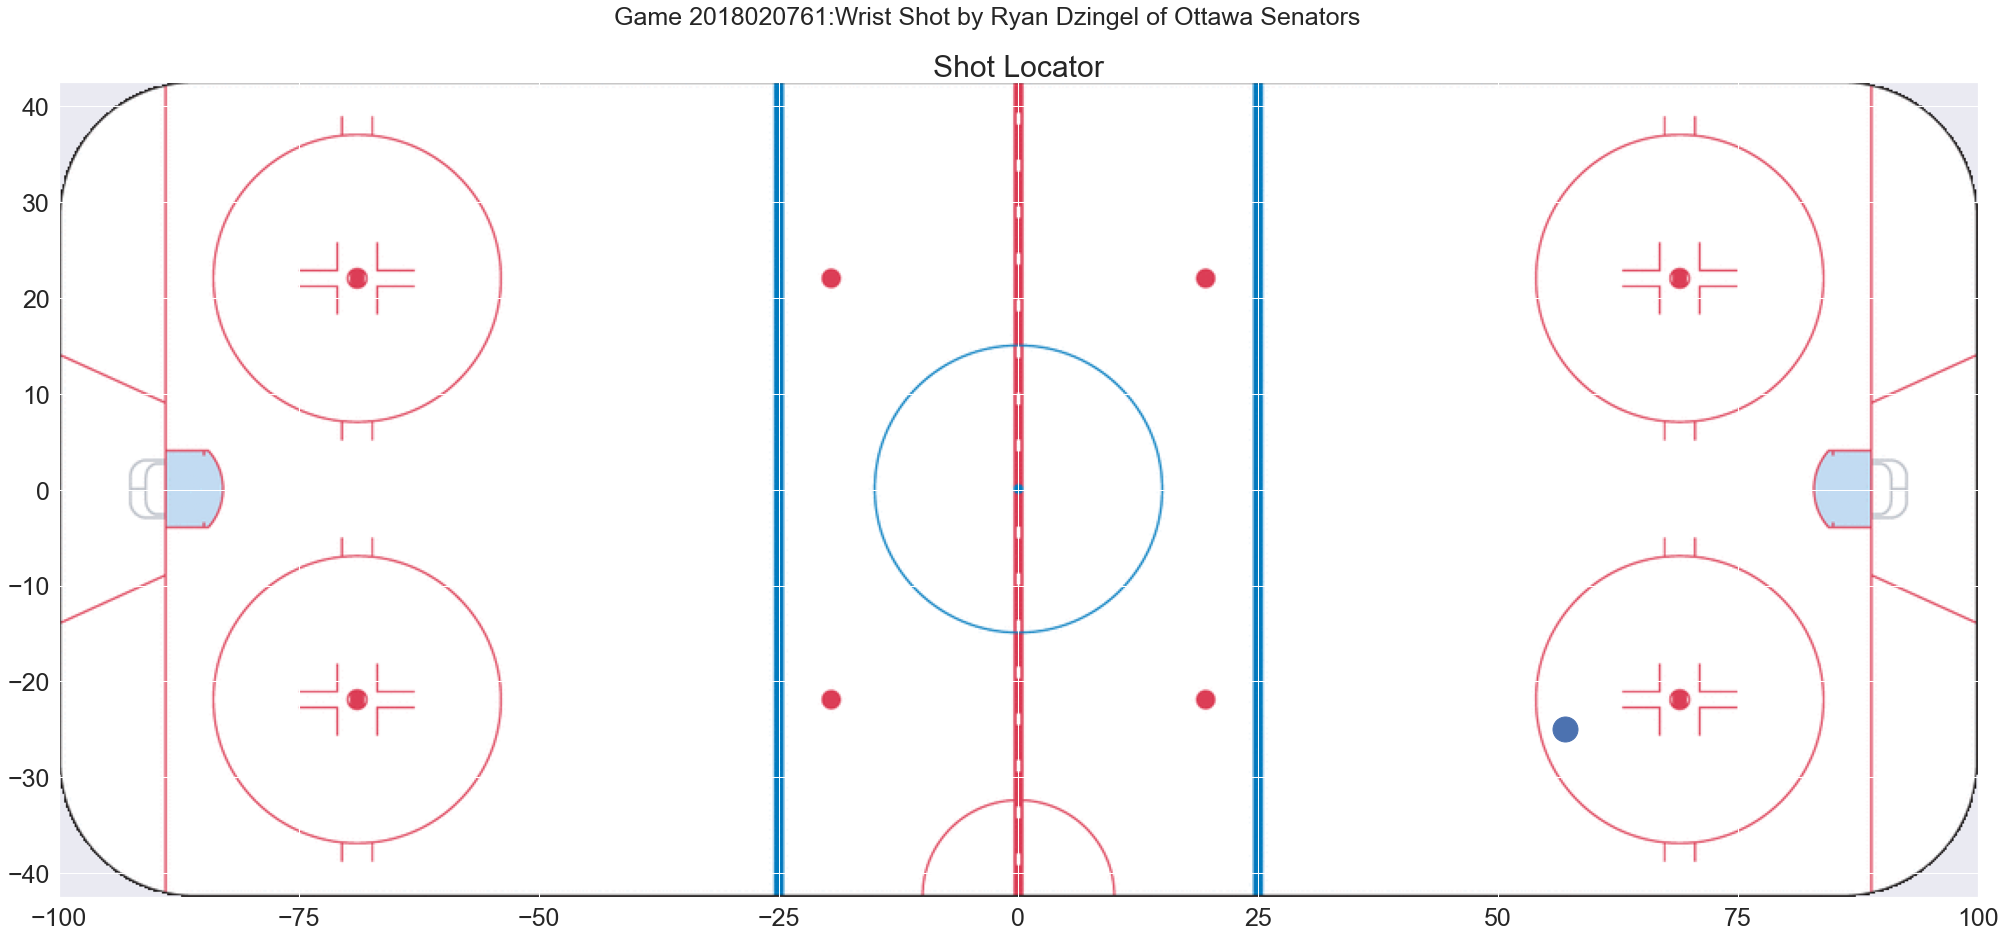

In [836]:
# Shot locator code

# df_group = df.loc[df['game_id'] == check]
# df_group = df_group.loc[df['event_id'] == temp]
# player=df_group['attacking_player'].tolist()
# team=df_group['attacking_team'].tolist()
# type=df_group['shot_type'].tolist()
# img = plt.imread('C:\\Users\\chait\\OneDrive\\Desktop\\IFT_6758_figures\\nhl_rink.png') 
# fig = plt.figure(figsize=(35,15))
# fig.suptitle(f'Game {check}:{type[0]} by {player[0]} of {team[0]}',fontsize=25,y=.95)
# ax1 = fig.add_subplot(1,1,1)
# ax1.tick_params(labelsize=25)
# ax1.imshow(img,extent=[-100,100,-42.5,42.5])
# ax1.plot(df_group['x_coordinates'],df_group['y_coordinates'],'b.',markersize=50)
# ax1.set_title("Shot Locator",fontsize=30)
# ax1.set_xlim(-100,100)
# ax1.set_ylim(-42.5,42.5)
# None

In [ ]:
df_group = df.groupby('home_team')
df_group2 = df_group1.get_group(Home_team.value)

## 4. Tidy Data (10%)

Now that you’ve obtained and explored the data a bit, we need to format the data in a way that will make it easier to do data science (i.e. tidy the data)! We generally want to work with nice Pandas dataframes rather than raw data, so here you are tasked with processing the raw event data from every game into dataframes that will be usable for the subsequent tasks. You may find this endpoint useful:

https://statsapi.web.nhl.com/api/v1/playTypes

Create a function to convert all events of every game into a pandas dataframe. For this milestone, you will want to include events of the type “shots” and “goals”. You can ignore missed shots or blocked shots for now. For each event, you will want to include as features (at minimum): game time/period information, game ID, team information (which team took the shot), indicator if its a shot or a goal, the on-ice coordinates, the shooter and goalie name (don’t worry about assists for now), shot type, if it was on an empty net, and whether or not a goal was at even strength, shorthanded, or on the power play.

In [76]:
def get_player_name(event, role):

    assert role in ['Goalie','Shooter','Scorer'], "selected role not supported"
    for player in event['players']:
        if (player['playerType'] == role):
            return player['player']['fullName']

In [77]:
def return_dict_value_if_exists(dic, key):
    if key in dic.keys():
        return dic[key]
    else:
        return None

In [78]:
def return_list_value_if_exists(lst, pos):
    if len(lst) > pos :
        return lst[pos]
    else:
        return None

In [16]:
def get_distance_from_net_and_side(df, net_distance_from_center = 89):
    
    """
    Compute the distance from where a shot was taken to the goal line
    
    

    source: https://community.rapidminer.com/discussion/44904/using-the-nhl-api-to-analyze-pro-ice-hockey-data-part-1
    """
    
    df['coordinates_multiplier'] = 1 -\
                                   2 * (df['home_team_side_1st_period']=='right') * (((df['attacking_team'] == df['home_team']) & df['period'].isin([1,3,5,7,9])) | ((df['attacking_team'] == df['away_team']) & df['period'].isin([2,4,6,8]))) -\
                                   2 * (df['home_team_side_1st_period']=='left') * (((df['attacking_team'] == df['home_team']) & df['period'].isin([2,4,6,8])) | ((df['attacking_team'] == df['away_team']) & df['period'].isin([1,3,5,7,9])))
    df['distance_from_net'] = df['home_team_side_1st_period'].isnull() * \
                                  np.minimum(
                                             ((df['x_coordinates'] - net_distance_from_center)**2 + (df['y_coordinates'] - 0)**2)**0.5,
                                             ((df['x_coordinates'] + net_distance_from_center)**2 + (df['y_coordinates'] - 0)**2)**0.5
                                  ) + \
                              ~df['home_team_side_1st_period'].isnull() * \
                                  ((df['x_coordinates'] - net_distance_from_center * df['coordinates_multiplier'])**2 + (df['y_coordinates'] - 0)**2)**0.5
    df['attacking_team_side'] = np.where(df['coordinates_multiplier'] == 1, 'left', 'right')
    del df['coordinates_multiplier']
    
    return df

In [748]:
def return_tidy_df(games, clear_games = True):
    
    data = []
    
    for game in games:

        game_id = game['gameData']['game']['pk']
        season = game['gameData']['game']['season']
        season_type = game['gameData']['game']['type']
        home_team = game['gameData']['teams']['home']['name']
        away_team = game['gameData']['teams']['away']['name']
        d = return_list_value_if_exists(game['liveData']['linescore']['periods'], 0)
        if d is not None: 
            home_team_side_1st_period =  return_dict_value_if_exists(d['home'], 'rinkSide')
        else:
            home_team_side_1st_period = None
        
        events = game['liveData']['plays']['allPlays']

        for event in events:
            
            event_type = event['result']['event']

            if event_type == 'Shot':
                event_id = event['about']['eventIdx']
                attacking_team = event['team']['name']
                attacking_player = get_player_name(event, 'Shooter')
                goalie = get_player_name(event, 'Goalie')
                period = event['about']['period']
                period_time = event['about']['periodTime']
                goal_ind = 0
                shot_ind = 1
                x_coordinates = return_dict_value_if_exists(event['coordinates'], 'x')
                y_coordinates = return_dict_value_if_exists(event['coordinates'], 'y')
#                shot_type = event['result']['secondaryType']
                shot_type = event['result'].get('secondaryType')
                empty_net = None
                strength = None
                gwg = None

                data.append([game_id, season, season_type, event_id, home_team, away_team, home_team_side_1st_period,
                             attacking_team, attacking_player, goalie, period, period_time, goal_ind, 
                             shot_ind, x_coordinates, y_coordinates, shot_type, empty_net, strength, gwg])

            elif event_type == 'Goal':
                event_id = event['about']['eventIdx']
                attacking_team = event['team']['name']
                attacking_player = get_player_name(event, 'Scorer')
                goalie = get_player_name(event, 'Goalie')
                period = event['about']['period']
                period_time = event['about']['periodTime']
                goal_ind = 1
                shot_ind = 0
                x_coordinates = return_dict_value_if_exists(event['coordinates'], 'x')
                y_coordinates = return_dict_value_if_exists(event['coordinates'], 'y')
                shot_type = return_dict_value_if_exists(event['result'], 'secondaryType')
                empty_net = return_dict_value_if_exists(event['result'], 'emptyNet')
                strength = event['result']['strength']['name']
                gwg = event['result']['gameWinningGoal']
                
                data.append([game_id, season, season_type, event_id, home_team, away_team, home_team_side_1st_period,
                             attacking_team, attacking_player, goalie, period, period_time, goal_ind, 
                             shot_ind, x_coordinates, y_coordinates, shot_type, empty_net, strength, gwg])

    df = pd.DataFrame(data, 
                      columns=['game_id', 'season', 'season_type','event_id' ,'home_team', 'away_team', 'home_team_side_1st_period', 
                               'attacking_team', 'attacking_player', 'goalie', 'period', 'period_time','goal_ind', 
                               'shot_ind', 'x_coordinates', 'y_coordinates', 'shot_type', 'empty_net', 'strength', 'gwg'])
    
    df = get_distance_from_net_and_side(df, net_distance_from_center = 89)
    
    if clear_games:
        del games
        
    return df

In [750]:
df = return_tidy_df(result_file, clear_games = False)
df.sample(10)

,game_id,season,season_type,event_id,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,period,period_time,goal_ind,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side
63908,2018021010,20182019,R,210,New York Islanders,Philadelphia Flyers,left,Philadelphia Flyers,Sean Couturier,Thomas Greiss,2,15:14,1,0,82.0,5.0,Deflected,False,Even,False,8.602325,left
8213,2018020130,20182019,R,282,New York Islanders,Florida Panthers,left,Florida Panthers,Jared McCann,Robin Lehner,3,11:20,0,1,-78.0,-21.0,Wrist Shot,None,None,None,23.706539,right
79424,2018021255,20182019,R,301,Chicago Blackhawks,Dallas Stars,right,Chicago Blackhawks,Patrick Kane,Anton Khudobin,3,19:21,0,1,-74.0,-23.0,Wrist Shot,None,None,None,27.459060,right
5562,2018020089,20182019,R,54,Anaheim Ducks,New York Islanders,left,Anaheim Ducks,Hampus Lindholm,Thomas Greiss,1,11:14,0,1,-5.0,4.0,Wrist Shot,None,None,None,94.085068,left
7307,2018020116,20182019,R,263,Chicago Blackhawks,Tampa Bay Lightning,right,Chicago Blackhawks,Jonathan Toews,Louis Domingue,3,12:05,0,1,-53.0,27.0,Wrist Shot,None,None,None,45.000000,right
7989,2018020127,20182019,R,130,Chicago Blackhawks,Anaheim Ducks,right,Anaheim Ducks,Cam Fowler,Corey Crawford,2,02:31,0,1,-48.0,-25.0,Slap Shot,None,None,None,48.020829,right
24127,2018020380,20182019,R,19,Calgary Flames,Dallas Stars,right,Calgary Flames,TJ Brodie,Anton Khudobin,1,02:18,0,1,6.0,33.0,Wrist Shot,None,None,None,100.568385,right
49495,2018020788,20182019,R,10,Dallas Stars,Minnesota Wild,right,Dallas Stars,Brett Ritchie,Devan Dubnyk,1,02:05,0,1,-78.0,24.0,Wrist Shot,None,None,None,26.400758,right
77143,2018021220,20182019,R,125,San Jose Sharks,Calgary Flames,left,Calgary Flames,Michael Frolik,Aaron Dell,2,01:00,0,1,51.0,21.0,Wrist Shot,None,None,None,43.416587,left
16458,2018020259,20182019,R,113,Edmonton Oilers,Colorado Avalanche,left,Colorado Avalanche,Tyson Jost,Cam Talbot,2,04:57,0,1,83.0,-5.0,Slap Shot,None,None,None,7.810250,left


In [763]:
df_group = df.loc[df['game_id'] == 2018020380]
df_group.head()

,game_id,season,season_type,event_id,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,period,period_time,goal_ind,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side,game_id_numeric
24123,2018020380,20182019,R,7,Calgary Flames,Dallas Stars,right,Dallas Stars,Jason Spezza,David Rittich,1,00:41,1,0,69.0,0.0,Snap Shot,False,Even,False,20.000000,left,2018020380
24124,2018020380,20182019,R,10,Calgary Flames,Dallas Stars,right,Calgary Flames,Mikael Backlund,Anton Khudobin,1,01:18,0,1,-48.0,-22.0,Slap Shot,None,None,None,46.529560,right,2018020380
24125,2018020380,20182019,R,13,Calgary Flames,Dallas Stars,right,Calgary Flames,Travis Hamonic,Anton Khudobin,1,01:27,0,1,-42.0,22.0,Slap Shot,None,None,None,51.894123,right,2018020380
24126,2018020380,20182019,R,14,Calgary Flames,Dallas Stars,right,Dallas Stars,Devin Shore,David Rittich,1,01:35,0,1,79.0,1.0,Wrist Shot,None,None,None,10.049876,left,2018020380
24127,2018020380,20182019,R,19,Calgary Flames,Dallas Stars,right,Calgary Flames,TJ Brodie,Anton Khudobin,1,02:18,0,1,6.0,33.0,Wrist Shot,None,None,None,100.568385,right,2018020380


In [22]:
df.isnull().sum()

game_id                          0
season                           0
season_type                      0
home_team                        0
away_team                        0
home_team_side_1st_period     2874
attacking_team                   0
attacking_player                 0
goalie                         439
period                           0
period_time                      0
goal_ind                         0
shot_ind                         0
x_coordinates                    3
y_coordinates                    2
shot_type                        9
empty_net                    77877
strength                     77689
gwg                          77689
distance_from_net                4
attacking_team_side              0
dtype: int64

### 4.Q1 
In your blog post, include a small snippet of your final dataframe (e.g. using head(10)). You can just include a screenshot rather than fighting to get the tables neatly formatted in HTML/markdown. 

In [23]:
df.sample(10)

,game_id,season,season_type,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,period,period_time,goal_ind,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side
35131,2018020556,20182019,R,Minnesota Wild,Dallas Stars,right,Minnesota Wild,Mikko Koivu,Ben Bishop,1,04:16,0,1,-30.0,30.0,Slap Shot,None,None,None,66.189123,right
15820,2018020249,20182019,R,Pittsburgh Penguins,Arizona Coyotes,left,Arizona Coyotes,Alex Galchenyuk,Casey DeSmith,3,00:59,0,1,-61.0,3.0,Backhand,None,None,None,28.160256,right
35893,2018020568,20182019,R,New York Rangers,Columbus Blue Jackets,right,Columbus Blue Jackets,Seth Jones,Henrik Lundqvist,2,01:59,0,1,-31.0,30.0,Wrist Shot,None,None,None,65.299311,right
15852,2018020250,20182019,R,Carolina Hurricanes,Detroit Red Wings,right,Detroit Red Wings,Trevor Daley,Scott Darling,1,06:42,0,1,36.0,35.0,Slap Shot,None,None,None,63.513778,left
40811,2018020645,20182019,R,Arizona Coyotes,New York Rangers,left,Arizona Coyotes,Conor Garland,Henrik Lundqvist,2,10:54,0,1,-63.0,-15.0,Wrist Shot,None,None,None,30.016662,right
3984,2018020064,20182019,R,Florida Panthers,Vancouver Canucks,right,Florida Panthers,Keith Yandle,Anders Nilsson,1,04:46,0,1,-37.0,3.0,Slap Shot,None,None,None,52.086467,right
4149,2018020067,20182019,R,Dallas Stars,Anaheim Ducks,right,Anaheim Ducks,Sam Steel,Anton Khudobin,1,05:46,0,1,64.0,-19.0,Wrist Shot,None,None,None,31.400637,left
3413,2018020055,20182019,R,Nashville Predators,Winnipeg Jets,left,Nashville Predators,Colton Sissons,Connor Hellebuyck,1,11:02,0,1,69.0,7.0,Snap Shot,None,None,None,21.189620,left
72996,2018021155,20182019,R,Montréal Canadiens,Buffalo Sabres,right,Montréal Canadiens,Brendan Gallagher,Carter Hutton,2,05:39,0,1,79.0,-1.0,Wrist Shot,None,None,None,10.049876,left
35269,2018020558,20182019,R,Vancouver Canucks,Winnipeg Jets,right,Vancouver Canucks,Josh Leivo,Laurent Brossoit,1,11:42,0,1,-64.0,19.0,Wrist Shot,None,None,None,31.400637,right


### 4.Q2
You’ll notice that the “strength” field (i.e. even, power play, short handed) only exists for goals, not shots. Furthermore, it doesn’t include the actual strength of players on the ice (i.e. 5 on 4, or 5 on 3, etc). Discuss how you could add the actual strength information (i.e. 5 on 4, etc.) to both shots and goals, given the other event types (beyond just shots and goals) and features available. You don’t need to implement this for this milestone.

A: By looking at the 'Penalty' and 'Goal' events you can logically deduce the stregh at any given time in the game (by looking at penalty times, goals, etc). For each game, you can start  by building a table which contains the strengh at every second the game. Then, when you get the events data, get the strengh from that table for shots.

In [24]:
result_file[0]['liveData']['plays']['allPlays'][38] #sample penalty event

{'players': [{'player': {'id': 8478408,
    'fullName': 'Travis Dermott',
    'link': '/api/v1/people/8478408'},
   'playerType': 'PlayerID'}],
 'result': {'event': 'Giveaway',
  'eventCode': 'TOR167',
  'eventTypeId': 'GIVEAWAY',
  'description': 'Giveaway by Travis Dermott'},
 'about': {'eventIdx': 38,
  'eventId': 167,
  'period': 1,
  'periodType': 'REGULAR',
  'ordinalNum': '1st',
  'periodTime': '08:11',
  'periodTimeRemaining': '11:49',
  'dateTime': '2018-10-03T23:30:07Z',
  'goals': {'away': 0, 'home': 0}},
 'coordinates': {'x': 16.0, 'y': 38.0},
 'team': {'id': 10,
  'name': 'Toronto Maple Leafs',
  'link': '/api/v1/teams/10',
  'triCode': 'TOR'}}

### 4.Q3 
In a few sentences, discuss some additional features you could consider creating from the data available in this dataset. We’re not looking for any particular answers, but if you need some inspiration, could a shot or goal be classified as a rebound, or a shot off the rush?

A:
- Based on coordinates, you could classify shots as low/high danger or as coming from a particular zone
- Shot/goal can be probably be classified as a rebound if there was another shot from the same team < x seconds prior (not 100% accurate though)
- Im not seeing a reliable method to classify a shot/goal as being off the rush
- anything that can be created from the set of events below

{'Blocked Shot',
 'Faceoff',
 'Game End',
 'Game Official',
 'Game Scheduled',
 'Giveaway',
 'Goal',
 'Hit',
 'Missed Shot',
 'Penalty',
 'Period End',
 'Period Official',
 'Period Ready',
 'Period Start',
 'Shot',
 'Stoppage',
 'Takeaway'}

## 5. Simple Visualizations (25%)

### 5.Q1
Produce a histogram of shot types over all teams in a season of your choosing. Overlay the number of goals overtop the number of shots. What appears to be the most dangerous type of shot? The most common type of shot? Add this figure and discussion to your blog post.

A: most common: wrist shot. most dangerous: can't really tell from the graph, would have to rescale it. looking at the data it appears to be tip-ins

<ipython-input-30-c25e2cf5f7dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20202021['shot_count'] = 1


<AxesSubplot:xlabel='shot_type'>

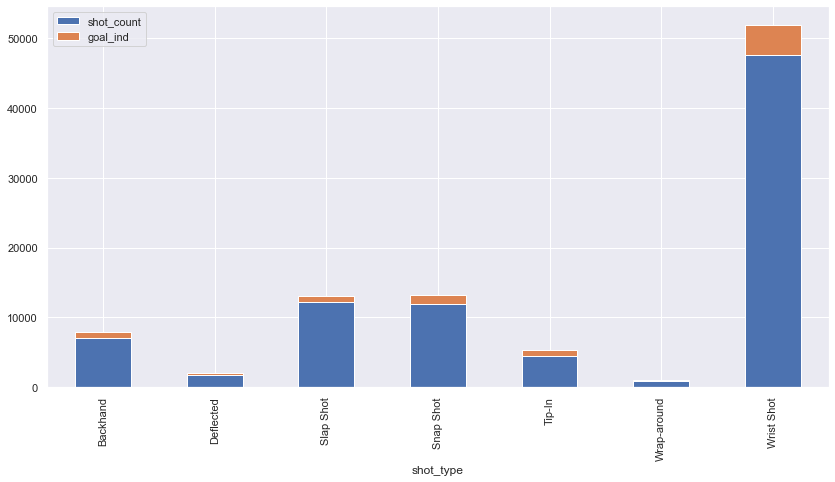

In [30]:
df_20202021 = df[(df['season'] == '20182019') & (~df['shot_type'].isnull())]
df_20202021['shot_count'] = 1
df_20202021 = df_20202021[['shot_type','shot_count', 'goal_ind']].groupby('shot_type').sum().reset_index()
sns.set_theme()
df_20202021.set_index('shot_type').plot(kind='bar', stacked=True, figsize=(14,7))

In [24]:
df_20202021['shot_pct'] = df_20202021['goal_ind'] / df_20202021['shot_count']
df_20202021

,shot_type,shot_count,goal_ind,shot_pct
0,Backhand,4453,538,0.120817
1,Deflected,1168,182,0.155822
2,Slap Shot,7982,560,0.070158
3,Snap Shot,7800,812,0.104103
4,Tip-In,2797,504,0.180193
5,Wrap-around,559,38,0.067979
6,Wrist Shot,32971,2998,0.090928


### 5.Q2
What is the relationship between the distance a shot was taken and the chance it was a goal? Produce a figure for each season between 2018-19 to 2020-21 to answer this, and add it to your blog post along with a couple of sentences describing your figure. Has there been much change over the past three seasons? Note: there are multiple ways to show this relationship! If your figure tells the correct story, you will get full marks

A:
- closer = higher chance up to about 75 ft
- after that, its hard to tell due to sample size but there seems to be an uptick. Probably due to empty net goals

TODO:
- get data for the other seasons and check for pattern

<ipython-input-25-59e3795f4708>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


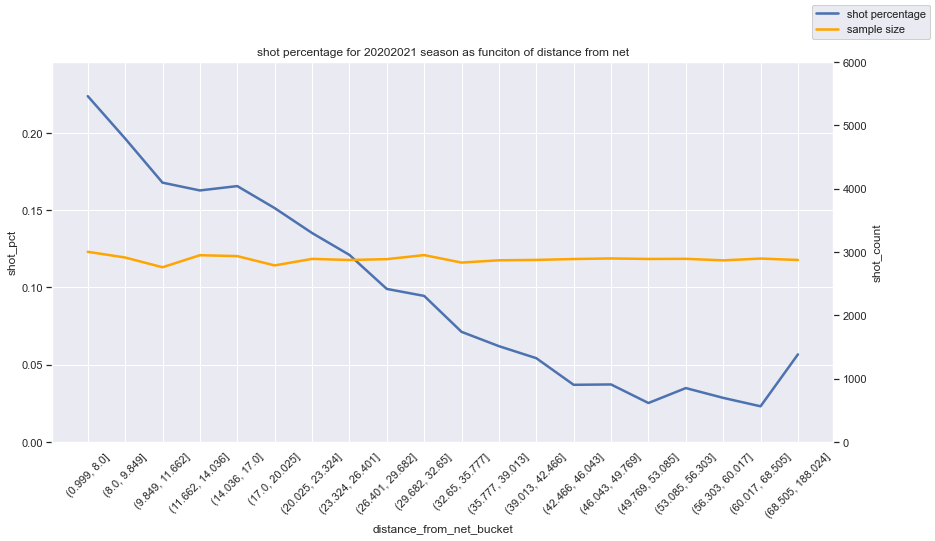

In [25]:
n_buckets = 20


df['distance_from_net_bucket'] = pd.qcut(df['distance_from_net'], n_buckets, labels = False) +1
intervals = list(set(pd.qcut(df['distance_from_net'], n_buckets)))
intervals.sort()
intervals = [str(interval) for interval in intervals]

df_copy = df.copy()
df_copy['shot_count'] = 1
df_copy = df_copy[['season','distance_from_net_bucket','shot_count','goal_ind']].groupby(['season','distance_from_net_bucket']).sum().reset_index()
df_copy['shot_pct'] = df_copy['goal_ind']/df_copy['shot_count']

y1_max = max(df_copy['shot_pct'])
y2_max = max(df_copy['shot_count'])

for season in ['20202021']:

    df_season = df_copy[df_copy['season'] == season]
    fig = plt.figure(figsize = (14,7))
    ax = sns.lineplot(x = 'distance_from_net_bucket', y = 'shot_pct', label='shot percentage', data = df_season, color='b', legend = False, linewidth = 2.5)
    ax.set_xticks(range(1,n_buckets+1))
    ax.set_xticklabels(intervals, rotation = 45)
    ax.set_ylim(bottom=0, top=y1_max * 1.1)
    ax2 = plt.twinx()
    ax2 = sns.lineplot(x = 'distance_from_net_bucket', y = 'shot_count', label='sample size', data = df_season, color='orange', legend = False, linewidth = 2.5)
    ax2.grid(False)
    ax2.set_ylim(bottom=0, top=y2_max * 2)
    fig.legend(loc="upper right")
    plt.title(f"shot percentage for {season} season as funciton of distance from net")
    fig.legend(loc="upper right")
    fig.show()

### 5.Q3
Combine the information from the previous sections to produce a figure that shows the goal percentage (# goals / # shots) as a function of both distance from the net, and the category of shot types (you can pick a single season of your choice). Briefly discuss your findings; e.g. what might be the most dangerous types of shots?

<ipython-input-26-a3630951a005>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


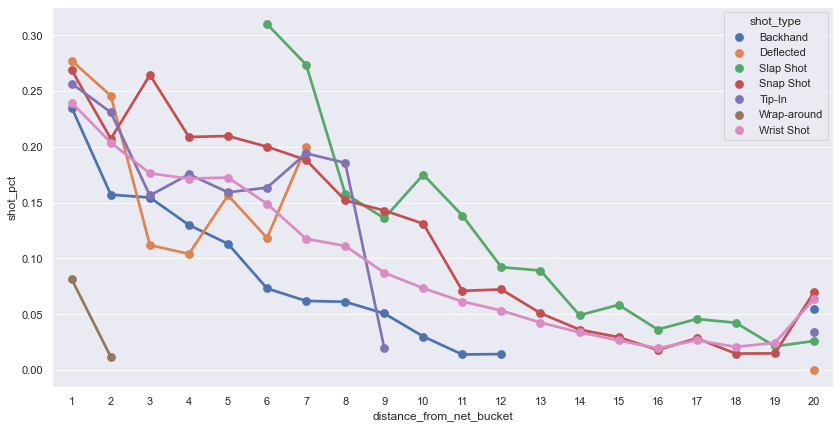

In [26]:
n_buckets = 20
season = '20202021'
min_sample_size = 50

df['distance_from_net_bucket'] = pd.qcut(df['distance_from_net'], n_buckets, labels = False) +1
intervals = list(set(pd.qcut(df['distance_from_net'], n_buckets)))
intervals.sort()
intervals = [str(interval) for interval in intervals]

df_copy = df.copy()
df_copy = df_copy[df_copy['season'] == season]
df_copy['shot_count'] = 1
df_copy = df_copy[['shot_type','distance_from_net_bucket','shot_count','goal_ind']].groupby(['shot_type','distance_from_net_bucket']).sum().reset_index()
df_copy = df_copy[df_copy['shot_count'] > min_sample_size]
df_copy['shot_pct'] = df_copy['goal_ind']/df_copy['shot_count']


y1_max = max(df_copy['shot_pct'])

fig = plt.figure(figsize = (14,7))
#sns.lineplot(x="distance_from_net_bucket", y="shot_pct", hue="shot_type", data=df_copy, marker="o")
sns.pointplot(x="distance_from_net_bucket", y="shot_pct", hue="shot_type", data=df_copy, marker="o")
#ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals, rotation = 45)
ax.set_ylim(bottom=0, top=y1_max * 1.1)
fig.show()

## 6. Advanced Visualizations: Shot Maps (30%)

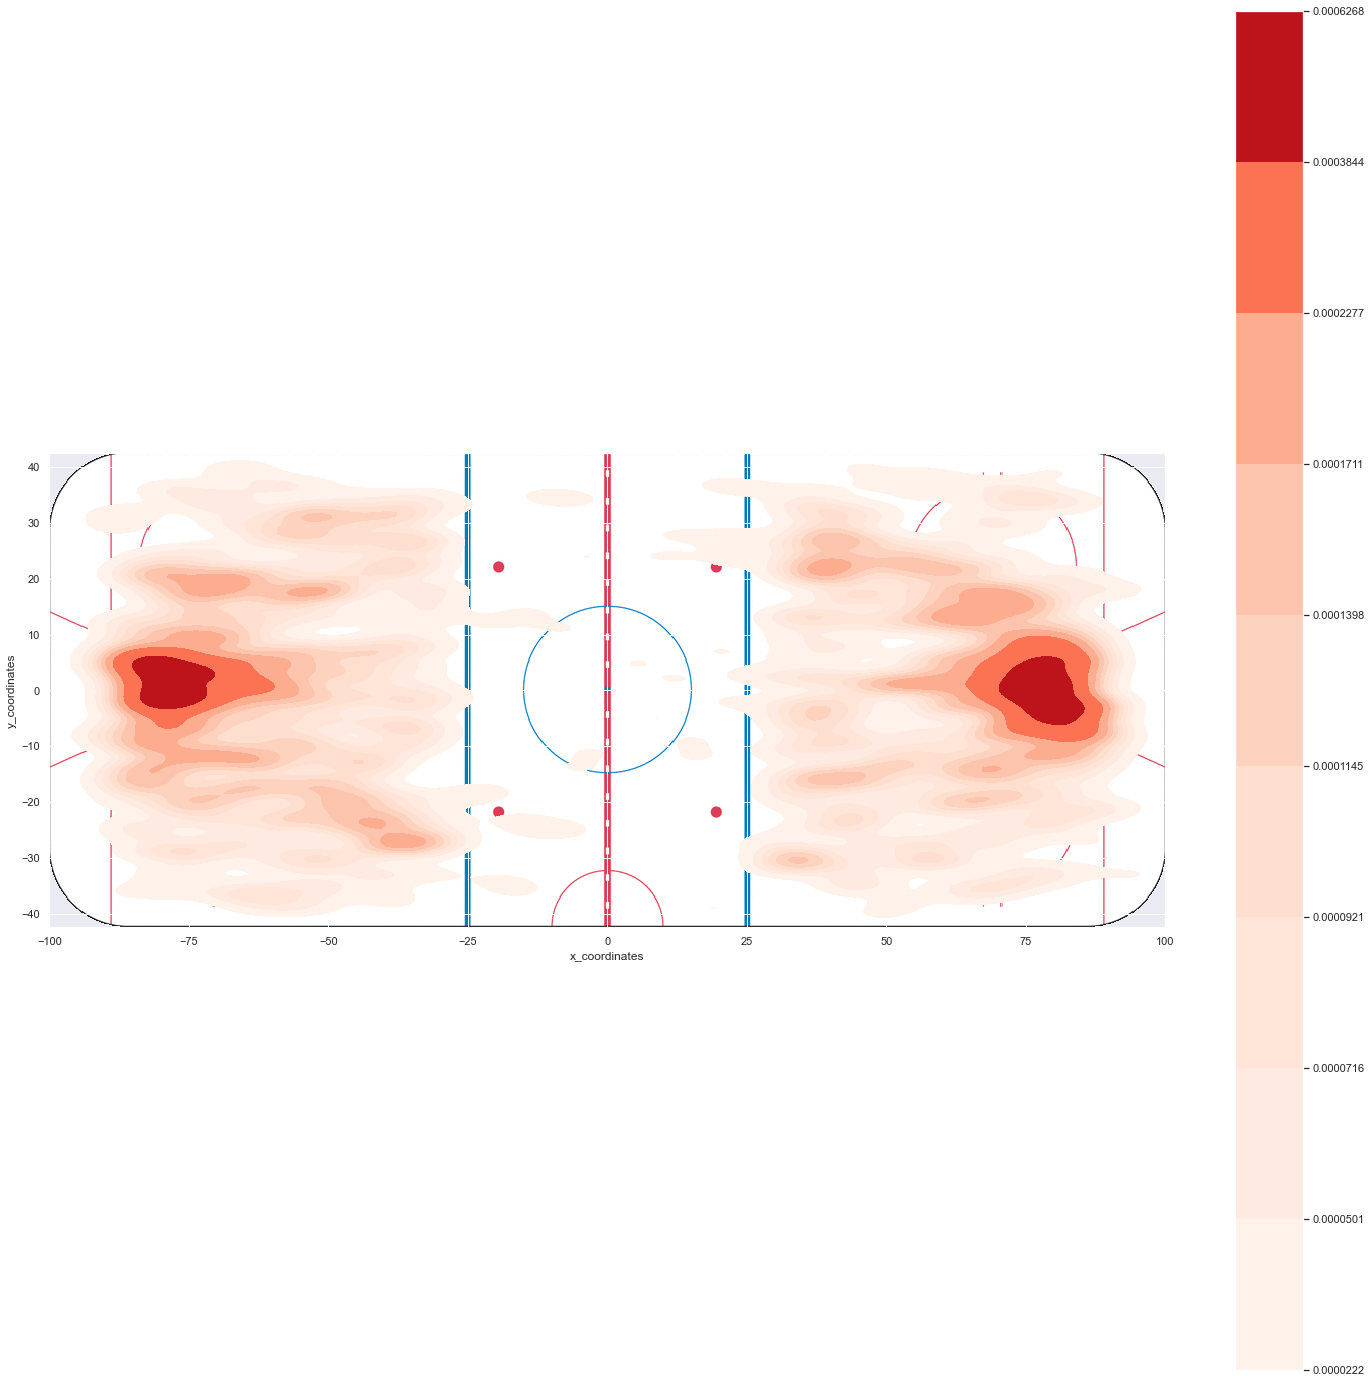

In [716]:
img = plt.imread('C:\\Users\\chait\\OneDrive\\Desktop\\IFT_6758_figures\\nhl_rink.png') 

fig, ax = plt.subplots(figsize= (25,25))

#plt.scatter(-60, 10, marker = 'X', s=200, c='black')
sns.kdeplot(x=df['x_coordinates'][0:1000], y=df['y_coordinates'][0:10000],  cmap="Reds", shade=True, cbar=True,bw_adjust=.25)
ax.imshow(img, interpolation='nearest', extent = [-100, 100, -42.5, 42.5])
plt.show()